In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from lusi.svm import SVMI
from lusi.invariants import *

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

# Baseline model

For the baseline model, we have selected the SVM with invariants using the following invariants:

- Positive class
- Mean in each dimension
- Box invariant

As for the data, we are going to split the data in two sets: a training set, containing 80% of the data and a test set with the remaining 20% of the data. Also, we are going to scale the data using a standard scaler.

In [2]:
diabetes_df = pd.read_csv('data/diabetes.csv')
diabetes_df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [3]:
# Get the data and split it in train and test
X, y = diabetes_df.drop('Outcome', axis=1).values, diabetes_df['Outcome'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=47)

In [4]:
# Scale the data
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

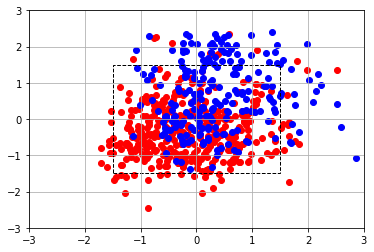

In [5]:
plt.scatter(X_train_scaled[y_train==0, 5], X_train_scaled[y_train==0, 1], c='r')
plt.scatter(X_train_scaled[y_train==1, 5], X_train_scaled[y_train==1, 1], c='b')

ax = plt.gca()
rectangle = patches.Rectangle((-1.5, -1.5), 3, 3, color='k', linestyle='--', fill=False)
ax.add_patch(rectangle)

plt.grid()
plt.xlim([-3, 3])
plt.ylim([-3, 3])


plt.show()

In [6]:
mean_in_dimension_invariants = [mean_in_dimension(i) for i in range(len(X_train_scaled[0]))]
invariants = [positive_class, box, *mean_in_dimension_invariants]

In [7]:
# Define and train a SVMI model
svmi_baseline = SVMI(C=1, kernel='rbf', gamma='auto', random_state=47)
svmi_baseline.fit(X_train_scaled, y_train, invariant_funcs=invariants)

In [8]:
y_pred = svmi_baseline.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of the SVMI using 10 invariants: {accuracy}')

Accuracy of the SVMI using 10 invariants: 0.7857142857142857


# Using random projections

Let's use only random projections now instead of the previously used invariants.

In [9]:
def run_random_projections_experiment(X_train, y_train, X_test, y_test, svm_parameters, num_repetitions=100, random_state=47):
    accuracies = []
    random_projection_invariants = []
    model_parameters = {**svm_parameters, 'random_state': random_state}

    print(f'\n\n------ EXPERIMENTS WITH RANDOM_STATE={random_state} ------\n')
    print(f'Parameters: {model_parameters}')

    # Run normal SVM and check its accuracy
    svc = SVC(**model_parameters)
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)

    print(f'Accuracy of SVC: {accuracy_score(y_test, y_pred)}')

    svmi_baseline = SVMI(**model_parameters)
    svmi_baseline.fit(X_train, y_train)

    y_pred = svmi_baseline.predict(X_test)
    print(f'Accuracy of SVM without invariants: {accuracy_score(y_test, y_pred)}')

    for _ in range(num_repetitions):
        random_projection_invariants.append(random_projection)

        svmi_random = SVMI(**model_parameters)
        svmi_random.fit(X_train, y_train, invariant_funcs=random_projection_invariants)

        y_pred = svmi_random.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))
    
    accuracies = np.array(accuracies)
    print(f'Maximum accuracy achieved with {np.argmax(accuracies) + 1} invariants: {np.max(accuracies)}')

    # Compute the mode of the accuracies
    accs, counts = np.unique(accuracies, return_counts=True)
    mode_idx = np.argmax(counts)
    print(f'Accuracy mode: {accs[mode_idx]}')
    
    return accuracies



------ EXPERIMENTS WITH RANDOM_STATE=42 ------

Parameters: {'C': 1.0, 'kernel': 'rbf', 'gamma': 'auto', 'random_state': 42}
Accuracy of SVC: 0.7727272727272727
Accuracy of SVM without invariants: 0.7792207792207793
Maximum accuracy achieved with 5 invariants: 0.7792207792207793
Accuracy mode: 0.7727272727272727


------ EXPERIMENTS WITH RANDOM_STATE=47 ------

Parameters: {'C': 1.0, 'kernel': 'rbf', 'gamma': 'auto', 'random_state': 47}
Accuracy of SVC: 0.7727272727272727
Accuracy of SVM without invariants: 0.7792207792207793
Maximum accuracy achieved with 1 invariants: 0.7792207792207793
Accuracy mode: 0.7727272727272727


------ EXPERIMENTS WITH RANDOM_STATE=937 ------

Parameters: {'C': 1.0, 'kernel': 'rbf', 'gamma': 'auto', 'random_state': 937}
Accuracy of SVC: 0.7727272727272727
Accuracy of SVM without invariants: 0.7792207792207793
Maximum accuracy achieved with 2 invariants: 0.7727272727272727
Accuracy mode: 0.7727272727272727


------ EXPERIMENTS WITH RANDOM_STATE=3889 ------

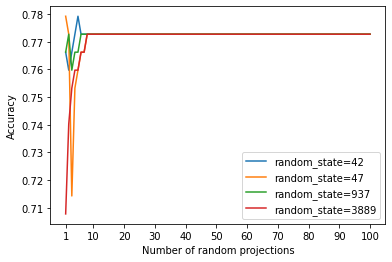

In [10]:
svm_parameters = {'C': 1.0, 'kernel': 'rbf', 'gamma': 'auto'}

accuracy_42 = run_random_projections_experiment(X_train_scaled, y_train, X_test_scaled, y_test, svm_parameters, random_state=42)
accuracy_47 = run_random_projections_experiment(X_train_scaled, y_train, X_test_scaled, y_test, svm_parameters, random_state=47)
accuracy_937 = run_random_projections_experiment(X_train_scaled, y_train, X_test_scaled, y_test, svm_parameters, random_state=937)
accuracy_3889 = run_random_projections_experiment(X_train_scaled, y_train, X_test_scaled, y_test, svm_parameters, random_state=3889)

x_range = np.arange(1, len(accuracy_42) + 1)

plt.plot(x_range, accuracy_42, label='random_state=42')
plt.plot(x_range, accuracy_47, label='random_state=47')
plt.plot(x_range, accuracy_937, label='random_state=937')
plt.plot(x_range, accuracy_3889, label='random_state=3889')

plt.xlabel('Number of random projections')
plt.ylabel('Accuracy')

plt.xticks([1, *range(10, len(accuracy_42) + 1, 10)])
plt.legend()
plt.show()



------ EXPERIMENTS WITH RANDOM_STATE=42 ------

Parameters: {'C': 1.0, 'kernel': 'rbf', 'gamma': 'auto', 'random_state': 42}
Accuracy of SVC: 0.7727272727272727
Accuracy of SVM without invariants: 0.7792207792207793
Maximum accuracy achieved with 5 invariants: 0.7792207792207793
Accuracy mode: 0.7727272727272727


------ EXPERIMENTS WITH RANDOM_STATE=47 ------

Parameters: {'C': 1.0, 'kernel': 'rbf', 'gamma': 'auto', 'random_state': 47}
Accuracy of SVC: 0.7727272727272727
Accuracy of SVM without invariants: 0.7792207792207793
Maximum accuracy achieved with 1 invariants: 0.7792207792207793
Accuracy mode: 0.7727272727272727


------ EXPERIMENTS WITH RANDOM_STATE=937 ------

Parameters: {'C': 1.0, 'kernel': 'rbf', 'gamma': 'auto', 'random_state': 937}
Accuracy of SVC: 0.7727272727272727
Accuracy of SVM without invariants: 0.7792207792207793
Maximum accuracy achieved with 2 invariants: 0.7727272727272727
Accuracy mode: 0.7727272727272727


------ EXPERIMENTS WITH RANDOM_STATE=3889 ------

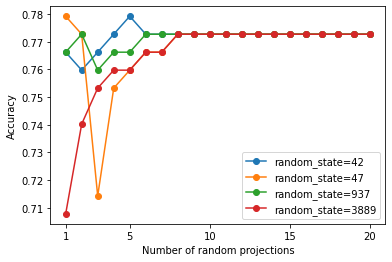

In [11]:
svm_parameters = {'C': 1.0, 'kernel': 'rbf', 'gamma': 'auto'}

accuracy_42 = run_random_projections_experiment(X_train_scaled, y_train, X_test_scaled, y_test, svm_parameters, num_repetitions=20, random_state=42)
accuracy_47 = run_random_projections_experiment(X_train_scaled, y_train, X_test_scaled, y_test, svm_parameters, num_repetitions=20, random_state=47)
accuracy_937 = run_random_projections_experiment(X_train_scaled, y_train, X_test_scaled, y_test, svm_parameters, num_repetitions=20, random_state=937)
accuracy_3889 = run_random_projections_experiment(X_train_scaled, y_train, X_test_scaled, y_test, svm_parameters, num_repetitions=20, random_state=3889)

x_range = np.arange(1, len(accuracy_42) + 1)

plt.plot(x_range, accuracy_42, label='random_state=42', marker='o')
plt.plot(x_range, accuracy_47, label='random_state=47', marker='o')
plt.plot(x_range, accuracy_937, label='random_state=937', marker='o')
plt.plot(x_range, accuracy_3889, label='random_state=3889', marker='o')

plt.xlabel('Number of random projections')
plt.ylabel('Accuracy')

plt.xticks([1, *range(5, len(accuracy_42) + 1, 5)])
plt.legend()
plt.show()



------ EXPERIMENTS WITH RANDOM_STATE=42 ------

Parameters: {'C': 0.01, 'kernel': 'rbf', 'gamma': 0.01, 'random_state': 42}
Accuracy of SVC: 0.7012987012987013
Accuracy of SVM without invariants: 0.7987012987012987
Maximum accuracy achieved with 1 invariants: 0.7987012987012987
Accuracy mode: 0.7987012987012987


------ EXPERIMENTS WITH RANDOM_STATE=47 ------

Parameters: {'C': 0.01, 'kernel': 'rbf', 'gamma': 0.01, 'random_state': 47}
Accuracy of SVC: 0.7012987012987013
Accuracy of SVM without invariants: 0.7987012987012987
Maximum accuracy achieved with 7 invariants: 0.7987012987012987
Accuracy mode: 0.7987012987012987


------ EXPERIMENTS WITH RANDOM_STATE=937 ------

Parameters: {'C': 0.01, 'kernel': 'rbf', 'gamma': 0.01, 'random_state': 937}
Accuracy of SVC: 0.7012987012987013
Accuracy of SVM without invariants: 0.7987012987012987
Maximum accuracy achieved with 2 invariants: 0.7987012987012987
Accuracy mode: 0.7987012987012987


------ EXPERIMENTS WITH RANDOM_STATE=3889 ------

P

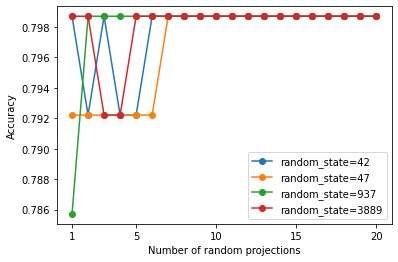

In [12]:
svm_parameters = {'C': 0.01, 'kernel': 'rbf', 'gamma': 0.01}

accuracy_42 = run_random_projections_experiment(X_train_scaled, y_train, X_test_scaled, y_test, svm_parameters, num_repetitions=20, random_state=42)
accuracy_47 = run_random_projections_experiment(X_train_scaled, y_train, X_test_scaled, y_test, svm_parameters, num_repetitions=20, random_state=47)
accuracy_937 = run_random_projections_experiment(X_train_scaled, y_train, X_test_scaled, y_test, svm_parameters, num_repetitions=20, random_state=937)
accuracy_3889 = run_random_projections_experiment(X_train_scaled, y_train, X_test_scaled, y_test, svm_parameters, num_repetitions=20, random_state=3889)

x_range = np.arange(1, len(accuracy_937) + 1)

plt.plot(x_range, accuracy_42, label='random_state=42', marker='o')
plt.plot(x_range, accuracy_47, label='random_state=47', marker='o')
plt.plot(x_range, accuracy_937, label='random_state=937', marker='o')
plt.plot(x_range, accuracy_3889, label='random_state=3889', marker='o')

plt.xlabel('Number of random projections')
plt.ylabel('Accuracy')

plt.xticks([1, *range(5, len(accuracy_937) + 1, 5)])
plt.legend()
plt.show()



------ EXPERIMENTS WITH RANDOM_STATE=42 ------

Parameters: {'C': 0.01, 'kernel': 'rbf', 'gamma': 'auto', 'random_state': 42}
Accuracy of SVC: 0.7012987012987013
Accuracy of SVM without invariants: 0.7467532467532467
Maximum accuracy achieved with 1 invariants: 0.7467532467532467
Accuracy mode: 0.7467532467532467


------ EXPERIMENTS WITH RANDOM_STATE=47 ------

Parameters: {'C': 0.01, 'kernel': 'rbf', 'gamma': 'auto', 'random_state': 47}
Accuracy of SVC: 0.7012987012987013
Accuracy of SVM without invariants: 0.7467532467532467
Maximum accuracy achieved with 1 invariants: 0.7467532467532467
Accuracy mode: 0.7467532467532467


------ EXPERIMENTS WITH RANDOM_STATE=937 ------

Parameters: {'C': 0.01, 'kernel': 'rbf', 'gamma': 'auto', 'random_state': 937}
Accuracy of SVC: 0.7012987012987013
Accuracy of SVM without invariants: 0.7467532467532467
Maximum accuracy achieved with 1 invariants: 0.7467532467532467
Accuracy mode: 0.7467532467532467


------ EXPERIMENTS WITH RANDOM_STATE=3889 ---

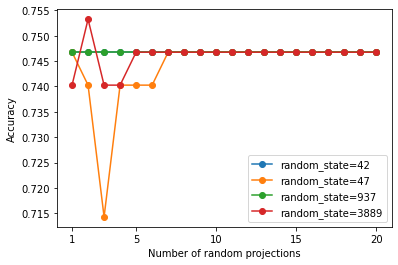

In [13]:
svm_parameters = {'C': 0.01, 'kernel': 'rbf', 'gamma': 'auto'}

accuracy_42 = run_random_projections_experiment(X_train_scaled, y_train, X_test_scaled, y_test, svm_parameters, num_repetitions=20, random_state=42)
accuracy_47 = run_random_projections_experiment(X_train_scaled, y_train, X_test_scaled, y_test, svm_parameters, num_repetitions=20, random_state=47)
accuracy_937 = run_random_projections_experiment(X_train_scaled, y_train, X_test_scaled, y_test, svm_parameters, num_repetitions=20, random_state=937)
accuracy_3889 = run_random_projections_experiment(X_train_scaled, y_train, X_test_scaled, y_test, svm_parameters, num_repetitions=20, random_state=3889)

x_range = np.arange(1, len(accuracy_42) + 1)

plt.plot(x_range, accuracy_42, label='random_state=42', marker='o')
plt.plot(x_range, accuracy_47, label='random_state=47', marker='o')
plt.plot(x_range, accuracy_937, label='random_state=937', marker='o')
plt.plot(x_range, accuracy_3889, label='random_state=3889', marker='o')

plt.xlabel('Number of random projections')
plt.ylabel('Accuracy')

plt.xticks([1, *range(5, len(accuracy_42) + 1, 5)])
plt.legend()
plt.show()

# Using less training samples

Now we are going to test how the models behave using less training data.

Training samples: 384
Testing samples: 384


------ EXPERIMENTS WITH RANDOM_STATE=37 ------

Parameters: {'C': 1.0, 'kernel': 'rbf', 'gamma': 'auto', 'random_state': 37}
Accuracy of SVC: 0.7369791666666666
Accuracy of SVM without invariants: 0.7421875
Maximum accuracy achieved with 6 invariants: 0.7395833333333334
Accuracy mode: 0.7239583333333334


------ EXPERIMENTS WITH RANDOM_STATE=43 ------

Parameters: {'C': 1.0, 'kernel': 'rbf', 'gamma': 'auto', 'random_state': 43}
Accuracy of SVC: 0.7369791666666666
Accuracy of SVM without invariants: 0.7421875
Maximum accuracy achieved with 3 invariants: 0.7421875
Accuracy mode: 0.7239583333333334


------ EXPERIMENTS WITH RANDOM_STATE=937 ------

Parameters: {'C': 1.0, 'kernel': 'rbf', 'gamma': 'auto', 'random_state': 937}
Accuracy of SVC: 0.7369791666666666
Accuracy of SVM without invariants: 0.7421875
Maximum accuracy achieved with 1 invariants: 0.734375
Accuracy mode: 0.7239583333333334


------ EXPERIMENTS WITH RANDOM_STATE=3889 ------

P

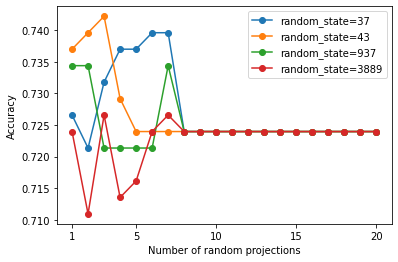

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=47)

# Scale the data
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'Training samples: {len(X_train_scaled)}')
print(f'Testing samples: {len(X_test_scaled)}')

svm_parameters = {'C': 1.0, 'kernel': 'rbf', 'gamma': 'auto'}

accuracy_37 = run_random_projections_experiment(X_train_scaled, y_train, X_test_scaled, y_test, svm_parameters, num_repetitions=20, random_state=37)
accuracy_43 = run_random_projections_experiment(X_train_scaled, y_train, X_test_scaled, y_test, svm_parameters, num_repetitions=20, random_state=43)
accuracy_937 = run_random_projections_experiment(X_train_scaled, y_train, X_test_scaled, y_test, svm_parameters, num_repetitions=20, random_state=937)
accuracy_3889 = run_random_projections_experiment(X_train_scaled, y_train, X_test_scaled, y_test, svm_parameters, num_repetitions=20, random_state=3889)

x_range = np.arange(1, len(accuracy_37) + 1)

plt.plot(x_range, accuracy_37, label='random_state=37', marker='o')
plt.plot(x_range, accuracy_43, label='random_state=43', marker='o')
plt.plot(x_range, accuracy_937, label='random_state=937', marker='o')
plt.plot(x_range, accuracy_3889, label='random_state=3889', marker='o')

plt.xlabel('Number of random projections')
plt.ylabel('Accuracy')

plt.xticks([1, *range(5, len(accuracy_37) + 1, 5)])
plt.legend()
plt.show()

Training samples: 230
Testing samples: 538


------ EXPERIMENTS WITH RANDOM_STATE=37 ------

Parameters: {'C': 1.0, 'kernel': 'rbf', 'gamma': 'auto', 'random_state': 37}
Accuracy of SVC: 0.741635687732342
Accuracy of SVM without invariants: 0.741635687732342
Maximum accuracy achieved with 2 invariants: 0.7453531598513011
Accuracy mode: 0.724907063197026


------ EXPERIMENTS WITH RANDOM_STATE=43 ------

Parameters: {'C': 1.0, 'kernel': 'rbf', 'gamma': 'auto', 'random_state': 43}
Accuracy of SVC: 0.741635687732342
Accuracy of SVM without invariants: 0.741635687732342
Maximum accuracy achieved with 3 invariants: 0.7360594795539034
Accuracy mode: 0.724907063197026


------ EXPERIMENTS WITH RANDOM_STATE=893 ------

Parameters: {'C': 1.0, 'kernel': 'rbf', 'gamma': 'auto', 'random_state': 893}
Accuracy of SVC: 0.741635687732342
Accuracy of SVM without invariants: 0.741635687732342
Maximum accuracy achieved with 8 invariants: 0.724907063197026
Accuracy mode: 0.724907063197026


------ EXPERIME

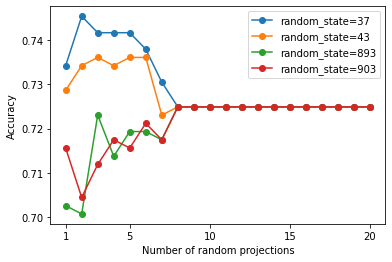

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.3, random_state=47)

# Scale the data
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'Training samples: {len(X_train_scaled)}')
print(f'Testing samples: {len(X_test_scaled)}')

svm_parameters = {'C': 1.0, 'kernel': 'rbf', 'gamma': 'auto'}

accuracy_37 = run_random_projections_experiment(X_train_scaled, y_train, X_test_scaled, y_test, svm_parameters, num_repetitions=20, random_state=37)
accuracy_43 = run_random_projections_experiment(X_train_scaled, y_train, X_test_scaled, y_test, svm_parameters, num_repetitions=20, random_state=43)
accuracy_893 = run_random_projections_experiment(X_train_scaled, y_train, X_test_scaled, y_test, svm_parameters, num_repetitions=20, random_state=893)
accuracy_903 = run_random_projections_experiment(X_train_scaled, y_train, X_test_scaled, y_test, svm_parameters, num_repetitions=20, random_state=903)

x_range = np.arange(1, len(accuracy_37) + 1)

plt.plot(x_range, accuracy_37, label='random_state=37', marker='o')
plt.plot(x_range, accuracy_43, label='random_state=43', marker='o')
plt.plot(x_range, accuracy_893, label='random_state=893', marker='o')
plt.plot(x_range, accuracy_903, label='random_state=903', marker='o')

plt.xlabel('Number of random projections')
plt.ylabel('Accuracy')

plt.xticks([1, *range(5, len(accuracy_37) + 1, 5)])
plt.legend()
plt.show()

Training samples: 153
Testing samples: 615


------ EXPERIMENTS WITH RANDOM_STATE=37 ------

Parameters: {'C': 1.0, 'kernel': 'rbf', 'gamma': 'auto', 'random_state': 37}
Accuracy of SVC: 0.7284552845528456
Accuracy of SVM without invariants: 0.7398373983739838
Maximum accuracy achieved with 3 invariants: 0.7479674796747967
Accuracy mode: 0.7300813008130081


------ EXPERIMENTS WITH RANDOM_STATE=43 ------

Parameters: {'C': 1.0, 'kernel': 'rbf', 'gamma': 'auto', 'random_state': 43}
Accuracy of SVC: 0.7284552845528456
Accuracy of SVM without invariants: 0.7398373983739838
Maximum accuracy achieved with 2 invariants: 0.7447154471544716
Accuracy mode: 0.7300813008130081


------ EXPERIMENTS WITH RANDOM_STATE=893 ------

Parameters: {'C': 1.0, 'kernel': 'rbf', 'gamma': 'auto', 'random_state': 893}
Accuracy of SVC: 0.7284552845528456
Accuracy of SVM without invariants: 0.7398373983739838
Maximum accuracy achieved with 8 invariants: 0.7300813008130081
Accuracy mode: 0.7300813008130081


-----

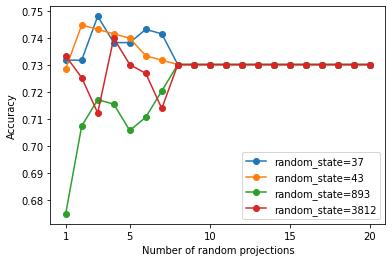

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, random_state=47)

# Scale the data
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'Training samples: {len(X_train_scaled)}')
print(f'Testing samples: {len(X_test_scaled)}')

svm_parameters = {'C': 1.0, 'kernel': 'rbf', 'gamma': 'auto'}

accuracy_37 = run_random_projections_experiment(X_train_scaled, y_train, X_test_scaled, y_test, svm_parameters, num_repetitions=20, random_state=37)
accuracy_43 = run_random_projections_experiment(X_train_scaled, y_train, X_test_scaled, y_test, svm_parameters, num_repetitions=20, random_state=43)
accuracy_893 = run_random_projections_experiment(X_train_scaled, y_train, X_test_scaled, y_test, svm_parameters, num_repetitions=20, random_state=893)
accuracy_3812 = run_random_projections_experiment(X_train_scaled, y_train, X_test_scaled, y_test, svm_parameters, num_repetitions=20, random_state=3812)

x_range = np.arange(1, len(accuracy_37) + 1)

plt.plot(x_range, accuracy_37, label='random_state=37', marker='o')
plt.plot(x_range, accuracy_43, label='random_state=43', marker='o')
plt.plot(x_range, accuracy_893, label='random_state=893', marker='o')
plt.plot(x_range, accuracy_3812, label='random_state=3812', marker='o')

plt.xlabel('Number of random projections')
plt.ylabel('Accuracy')

plt.xticks([1, *range(5, len(accuracy_37) + 1, 5)])
plt.legend()
plt.show()

Training samples: 76
Testing samples: 692


------ EXPERIMENTS WITH RANDOM_STATE=37 ------

Parameters: {'C': 1.0, 'kernel': 'rbf', 'gamma': 'auto', 'random_state': 37}
Accuracy of SVC: 0.7369942196531792
Accuracy of SVM without invariants: 0.7456647398843931
Maximum accuracy achieved with 4 invariants: 0.7355491329479769
Accuracy mode: 0.7326589595375722


------ EXPERIMENTS WITH RANDOM_STATE=43 ------

Parameters: {'C': 1.0, 'kernel': 'rbf', 'gamma': 'auto', 'random_state': 43}
Accuracy of SVC: 0.7369942196531792
Accuracy of SVM without invariants: 0.7456647398843931
Maximum accuracy achieved with 3 invariants: 0.75
Accuracy mode: 0.7326589595375722


------ EXPERIMENTS WITH RANDOM_STATE=893 ------

Parameters: {'C': 1.0, 'kernel': 'rbf', 'gamma': 'auto', 'random_state': 893}
Accuracy of SVC: 0.7369942196531792
Accuracy of SVM without invariants: 0.7456647398843931
Maximum accuracy achieved with 8 invariants: 0.7326589595375722
Accuracy mode: 0.7326589595375722


------ EXPERIMENTS W

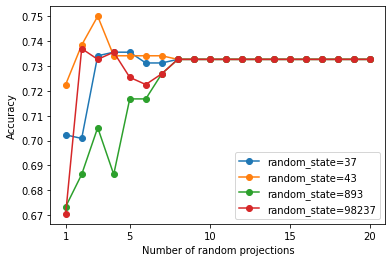

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1, random_state=47)

# Scale the data
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'Training samples: {len(X_train_scaled)}')
print(f'Testing samples: {len(X_test_scaled)}')

svm_parameters = {'C': 1.0, 'kernel': 'rbf', 'gamma': 'auto'}

accuracy_37 = run_random_projections_experiment(X_train_scaled, y_train, X_test_scaled, y_test, svm_parameters, num_repetitions=20, random_state=37)
accuracy_43 = run_random_projections_experiment(X_train_scaled, y_train, X_test_scaled, y_test, svm_parameters, num_repetitions=20, random_state=43)
accuracy_893 = run_random_projections_experiment(X_train_scaled, y_train, X_test_scaled, y_test, svm_parameters, num_repetitions=20, random_state=893)
accuracy_98237 = run_random_projections_experiment(X_train_scaled, y_train, X_test_scaled, y_test, svm_parameters, num_repetitions=20, random_state=98237)

x_range = np.arange(1, len(accuracy_37) + 1)

plt.plot(x_range, accuracy_37, label='random_state=37', marker='o')
plt.plot(x_range, accuracy_43, label='random_state=43', marker='o')
plt.plot(x_range, accuracy_893, label='random_state=893', marker='o')
plt.plot(x_range, accuracy_98237, label='random_state=98237', marker='o')

plt.xlabel('Number of random projections')
plt.ylabel('Accuracy')

plt.xticks([1, *range(5, len(accuracy_37) + 1, 5)])
plt.legend()
plt.show()

Training samples: 38
Testing samples: 730


------ EXPERIMENTS WITH RANDOM_STATE=12 ------

Parameters: {'C': 1.0, 'kernel': 'rbf', 'gamma': 'auto', 'random_state': 12}
Accuracy of SVC: 0.6876712328767123
Accuracy of SVM without invariants: 0.684931506849315
Maximum accuracy achieved with 1 invariants: 0.7
Accuracy mode: 0.6547945205479452


------ EXPERIMENTS WITH RANDOM_STATE=43 ------

Parameters: {'C': 1.0, 'kernel': 'rbf', 'gamma': 'auto', 'random_state': 43}
Accuracy of SVC: 0.6876712328767123
Accuracy of SVM without invariants: 0.684931506849315
Maximum accuracy achieved with 1 invariants: 0.6863013698630137
Accuracy mode: 0.6547945205479452


------ EXPERIMENTS WITH RANDOM_STATE=937 ------

Parameters: {'C': 1.0, 'kernel': 'rbf', 'gamma': 'auto', 'random_state': 937}
Accuracy of SVC: 0.6876712328767123
Accuracy of SVM without invariants: 0.684931506849315
Maximum accuracy achieved with 2 invariants: 0.689041095890411
Accuracy mode: 0.6547945205479452


------ EXPERIMENTS WITH R

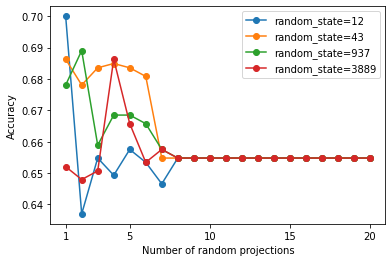

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.05, random_state=47)

# Scale the data
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'Training samples: {len(X_train_scaled)}')
print(f'Testing samples: {len(X_test_scaled)}')

svm_parameters = {'C': 1.0, 'kernel': 'rbf', 'gamma': 'auto'}

accuracy_12 = run_random_projections_experiment(X_train_scaled, y_train, X_test_scaled, y_test, svm_parameters, num_repetitions=20, random_state=12)
accuracy_43 = run_random_projections_experiment(X_train_scaled, y_train, X_test_scaled, y_test, svm_parameters, num_repetitions=20, random_state=43)
accuracy_937 = run_random_projections_experiment(X_train_scaled, y_train, X_test_scaled, y_test, svm_parameters, num_repetitions=20, random_state=937)
accuracy_3889 = run_random_projections_experiment(X_train_scaled, y_train, X_test_scaled, y_test, svm_parameters, num_repetitions=20, random_state=3889)

x_range = np.arange(1, len(accuracy_12) + 1)

plt.plot(x_range, accuracy_12, label='random_state=12', marker='o')
plt.plot(x_range, accuracy_43, label='random_state=43', marker='o')
plt.plot(x_range, accuracy_937, label='random_state=937', marker='o')
plt.plot(x_range, accuracy_3889, label='random_state=3889', marker='o')

plt.xlabel('Number of random projections')
plt.ylabel('Accuracy')

plt.xticks([1, *range(5, len(accuracy_37) + 1, 5)])
plt.legend()
plt.show()